[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example).

## State

#### Sub-graphs allow you to create and manage different states in different parts of your graph. 

This is particularly **useful for multi-agent systems, with teams of agents that each have their own state**.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

##### The most critical thing to understand is how the graphs communicate! 

In short, communication is **done with over-lapping keys**: 

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the logs that will be input to our graph.

In [1]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [ ]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs - For the states
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Sub graphs
- The sub graphs can have their own state keys (e.g. summary) that we dont care about in the overall parent state.
- As long as the key things i want to communicate between the parent and subgraphs are present in both places, they can effectively talk.
- In this case, `docs` i want to communicate to my subgraphs -> make sure the keys are overlapping (present in global/parent and subgraph state)
- I also want the `summary report`and `failure report`, to be accessible to my parent graph -> make sure the keys are overlapping (present in global/parent and subgraph state)

#### Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

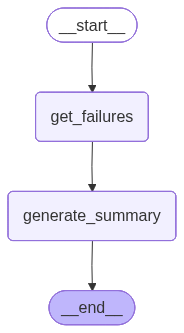

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph

# Failure Analysis State
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

# Failure Analysis Output State
class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

# node 1
def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

# node 2
def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    
    # Add fxn (function): fa_summary = summarize(failures)
    # Add a function here to actually summarize the failures, instead of hardcoding
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

# Defining the state_schema and the output_schema!
fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##### Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.

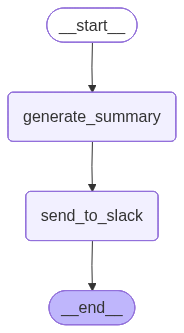

In [5]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

# node 1
def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]

    # Add fxn: summary = summarize(generate_summary)
    # Add a function here to actually summarize the questions, instead of hardcoding
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

# node 2
def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    # Add a function here to actually generate the report, instead of hardcoding
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph

Now, we can bring it all together.

#### We create our parent graph with `EntryGraphState`. 

#### And we add our sub-graphs as nodes! 

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

In [ ]:
# Entry Graph state - Global State
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FAILURE sub-graph
    report: str # This will only be generated in the QUESTION sub-graph
    processed_logs:  Annotated[List[str], add] # This will be generated in BOTH sub-graphs

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

##### This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

##### The sub-graphs are run in parallel.

#### Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

##### But, we can work around this by using another concept we talked about before.

> We can simply **create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.**

> We don't actually need each sub-graph to output `cleaned_logs`.

### What was happening before
- **Sub-graphs run in parallel** and **return a full state**.
- That means each sub-graph would **emit `cleaned_logs`** back to the parent state **even if they didn’t modify it**.
- When **two parallel branches return the same key**, LangGraph must know **how to combine** the two values.  
  → You saw `cleaned_logs: Annotated[List[Log], add]` so the framework could **reduce (merge)** the two lists using `operator.add`.

### What changed now
- Each sub-graph is compiled with an **output schema** that **does not include** `cleaned_logs`.  
  In other words, `cleaned_logs` is **only an input** to the sub-graphs and **is not published** back by them.
- Because **only the `clean_logs` node** writes `cleaned_logs` into the parent state, there’s **no parallel fan-in** on that key anymore.
- Result: you can declare `cleaned_logs: List[Log]` **without a reducer**, and it works — no merge needed.

### How to reason about it
- If **multiple branches** will emit the **same key**, you must **attach a reducer** to that key in the parent state (e.g., `add`, `max`, custom function).
- If a key is **only read** by branches (and **not returned** by them), **do not** put a reducer; just make sure the branches’ **output schemas exclude** that key.

### In this case
- The earlier section uses `Annotated[List[Log], add]` because both sub-graphs were implicitly returning `cleaned_logs`, causing a **fan-in**.
- The later code compiles sub-graphs with **narrow outputs**, so `cleaned_logs` isn’t returned by them, only **consumed**.  
  → Therefore, **no reducer** on `cleaned_logs` is required.



In [ ]:
# Entry Graph - Global State, optimized
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log] # no reducer needed as this is only consumed by the sub-graphs (not in their output schema -> this solves the collision issue)
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[str], add] # This will be generated in BOTH sub-graphs

# node 1
def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]

    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
#display(Image(graph.get_graph(xray=1).draw_mermaid_png())) # commented out as there was a mermaid API error

In [9]:
# Dummy logs for testing
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

**What this result shows (parent graph with two parallel sub-graphs):**

- `raw_logs`: the exact input you passed. The entry node doesn’t change it.
- `cleaned_logs`: produced by the `clean_logs` node (here it just copies `raw_logs`).  
  *No reducer is needed* because `cleaned_logs` is only **consumed** by the two sub-graphs and **not returned** by them.

- `failure_analysis` sub-graph output:
  - `fa_summary`: a single string summarizing the detected failure theme (e.g., *“Poor quality retrieval of Chroma documentation.”*).
  - `processed_logs`: items tagged by the FA branch (e.g., `failure-analysis-on-log-2`).

- `question_summarization` sub-graph output:
  - `report`: a single string (e.g., a combined/concise summary like `foo bar baz`).
  - `processed_logs`: items tagged by the QS branch (e.g., `summary-on-log-1`, `summary-on-log-2`).

- `processed_logs`: **merged list** from *both* sub-graphs.  
  This key is declared as `Annotated[List[str], add]` in the parent state, so LangGraph **reduces** (concatenates) the lists returned by the parallel branches:
  ['failure-analysis-on-log-2', 'summary-on-log-1', 'summary-on-log-2']


**Why these keys appear together:**
- The parent graph fans out from `clean_logs` into **two parallel branches** (`failure_analysis` and `question_summarization`) and then returns their outputs in the **same parent state**.
- Keys unique to a branch (`fa_summary`, `report`) show up once.
- Keys shared by both branches and meant to aggregate (`processed_logs`) **must** have a reducer (here, `add`), so their values are combined deterministically.



## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r

> The subgraphs traces are collapsable, which makes it easier to debug